In [146]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [147]:
path = 'lfw'

In [148]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [149]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


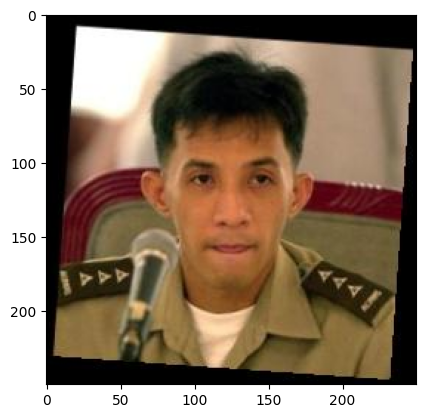

In [150]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

AutoEncoders and Variational AutoEncoders (VAEs) differ in several aspects:

1. **Applications**: AutoEncoders are great for noise reduction in images, anomaly detection, and feature extraction where the focus is on learning a compact representation. They're also used in pretraining for deep learning models. VAEs, by introducing randomness, are more suitable for complex generative tasks, like creating new images that mimic a given dataset, or for applications in semi-supervised learning where they can generate new labeled data.

2. **Architecture**: The encoder in an AutoEncoder maps the input to a latent space, and the decoder reconstructs the input from this latent space. In VAEs, the encoder outputs parameters of a probability distribution, introducing variability and uncertainty. This probabilistic approach allows VAEs to explore and generate a wider range of outputs than a standard AutoEncoder.

3. **Loss Function**: AutoEncoders typically use a simple loss function, like Mean Squared Error, focusing purely on reconstruction accuracy. VAEs combine reconstruction loss with the Kullback-Leibler divergence, enforcing a distribution (like Gaussian) on the encoded representations. This regularization term helps VAEs in learning a broader, more generalized representation of the input data, making them capable of generating new, diverse samples.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [151]:
import torch
from torch import nn
from torch.nn import functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        
        # Calculated the size of the flattened layer dynamically
        x = torch.ones(1, 3, 250, 250)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        self._to_linear = x.view(-1).shape[0]
        
        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.fc21 = nn.Linear(1024, 20)
        self.fc22 = nn.Linear(1024, 20)
        
        # Decoder
        self.fc3 = nn.Linear(20, 1024)
        self.fc4 = nn.Linear(1024, 256*16*16)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(-1, 256, 16, 16) # Reshape for the transposed convolutional layers
        
        # Use transposed convolutions to upsample to the previous layer's spatial dimensions
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        
        # Adjusted the kernel size, stride, and padding to get the desired output size
        z = self.deconv4(z)  # No need for activation here, as it will be applied after resizing

        # Resize to the correct output size if necessary
        z = F.interpolate(z, size=(250, 250), mode='bilinear', align_corners=False)
        z = torch.sigmoid(z)  # Applied sigmoid to scale the pixel values to [0, 1]
        return z

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
    
        mu = self.fc21(x)
        logvar = self.fc22(x)
    
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
    
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(-1, 256, 16, 16)  # Reshape for the transposed convolutional layers
    
        # Used transposed convolutions to upsample to the previous layer's spatial dimensions
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
    
        z = self.deconv4(z)  # No need for activation here, as it will be applied after resizing
    
        # Resize to the correct output size if necessary
        z = F.interpolate(z, size=(250, 250), mode='bilinear', align_corners=False)
        z = torch.sigmoid(z)  # Apply sigmoid to scale the pixel values to [0, 1]
        return z, mu, logvar



#### Encoder

The encoder's role is to process an input image and transform it into a lower-dimensional representation, often referred to as a "latent space." This is achieved through a series of convolutional and fully connected layers.

1. **Convolutional Layers**: The encoder begins with a set of convolutional layers (`self.conv1` to `self.conv4`). These layers perform feature extraction by applying learnable convolutional filters to the input image. The filters capture different aspects of the image, gradually reducing its spatial dimensions while increasing the number of channels (features).

2. **Dynamic Flattening**: To connect the convolutional layers to fully connected layers, you need to flatten the 3D feature maps into a 1D vector. We dynamically caluculated the flatten size of images for appropriate size of this flattened vector based on an example input image. This ensures that the network can handle input images of varying sizes.

3. **Fully Connected Layers (Linear Layers)**: Following the convolutional layers, the encoder includes fully connected layers (self.fc1, self.fc21, and self.fc22). These layers map the flattened feature vector to two sets of vectors: mu (mean) and logvar (log variance). These vectors describe the parameters of a probability distribution in the latent space.

#### Reparameterization Trick

The reparameterize technique plays a important role in the VAE. It enables the model to sample latent space points during training while still allowing for backpropagation through the network.

- **std Calculation**: The method calculates the standard deviation (std) from the log variance (logvar). By taking the exponential of half of logvar, it obtains the standard deviation. This transformation ensures that std is always positive.

- **Noise Generation**: It generates a random noise vector eps with the same shape as std. This noise introduces stochasticity into the sampling process.

- **Sampling**: The sampled latent space point is obtained by adding mu (mean) to the element-wise product of eps and std. This operation ensures that the sampling process is differentiable, allowing gradients to flow through during backpropagation.

#### Decoder 

The decoder's role is to take a point in the latent space and generate a reconstructed image from it. This process involves a series of fully connected and transposed convolutional layers, which upsample the latent representation to the original image size. The final output is a reconstructed image.

Overall, the VAE's encoder-decoder architecture allows it to learn a compact representation of input data in the latent space and generate new data samples by sampling from this space. The reparameterization technique is a key component that enables the model to learn and sample from a probabilistic latent space while maintaining differentiability for efficient training.

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [152]:
# Created an instance of the VAE class
model = VAE().to(device)

# Load data
dataiter = iter(dataloader)
images, _ = next(dataiter)
images = images.to(device)

# Passing an image through the model and get the encoder's output
with torch.no_grad():
    model.eval()
    mu, logvar = model.encode(images[0].unsqueeze(0))  # Process a single image
    print("Encoder output shapes - mu:", mu.shape, ", logvar:", logvar.shape)

    # Generated samples in the latent space and create new images
    samples = model.reparameterize(mu, logvar)
    generated_images = model.decode(samples)

    # Verifications for clear understanding
    print("Latent space sample shape:", samples.shape)
    print("Generated images shape:", generated_images.shape)
    print("Original vs Generated image size match:", images[0].size() == generated_images[0].size())

Encoder output shapes - mu: torch.Size([1, 20]) , logvar: torch.Size([1, 20])
Latent space sample shape: torch.Size([1, 20])
Generated images shape: torch.Size([1, 3, 250, 250])
Original vs Generated image size match: True


The loss function used here is a combination of two components: 

1. **Reconstruction Loss**:
   - The reconstruction loss measures how well the Variational Autoencoder (VAE) can reconstruct the input data from the latent space.
   - This loss shows the decoded outputs (reconstructed data) to be as close as possible to the original inputs.
   - Its goal is to ensure that the VAE learns a meaningful representation of the data in the latent space. A smaller reconstruction loss indicates better reconstruction of input data.

2. **KL Divergence Loss (Kullback-Leibler Divergence)**:
   - The KL divergence loss acts as a regularizer.
   - It measures the divergence between the distribution of the latent variables (as encoded from the input data) and a prior distribution, which is usually chosen to be a standard normal distribution (with mean=0 and variance=1).
   - This loss term encourages the latent space to have good properties, such as continuity and completeness.
   - It also ensures that the latent variables follow a distribution that is close to a standard normal distribution, making the generation process easier.
   - A smaller KL divergence loss indicates that the latent space has better properties, which facilitates better data generation and interpolation.

In summary, the reconstruction loss aims to make sure that the VAE can faithfully reconstruct input data, while the KL divergence loss encourages the latent space to have certain desired properties and be close to a standard normal distribution. The combination of these two loss terms enables the VAE to both accurately represent data and generate new, meaningful samples in the latent space.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [153]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)

Total number of trainable parameters: 127600363


In [154]:
import torch.nn.functional as F

def vae_loss(reconstructed_x, original_x, mean, log_variance):
    # Reconstruction Loss
    binary_cross_entropy_loss = F.binary_cross_entropy(reconstructed_x, original_x, reduction='sum')
    # Kullback-Leibler Divergence
    kl_divergence_loss = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())

    return binary_cross_entropy_loss + kl_divergence_loss

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#loss function
loss_function = lambda recon_x, x, mu, logvar: F.binary_cross_entropy(recon_x, x, reduction='sum') - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


# Step 6
 Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?


If the loss is not decreasing during training, here are the troubleshooting steps to consider:

1. **Learning Rate Adjustment**: One common issue is that the learning rate might be too high, causing the optimization process to overshoot the optimal solution. we can try reducing the learning rate to make smaller updates to the model weights and improve convergence.

2. **Loss Function**: we have to ensure that the loss function is correctly defined and properly balanced between the reconstruction loss and KL divergence loss. A difference in the loss terms can affect training. You can experiment with different weightings of these terms.

3. **Network Architecture**: Consider adjusting the architecture of the VAE, including the number of layers, hidden units, or latent space dimensionality. A more complex or larger model can be used to capture the data distribution effectively.

4. **Data Preprocessing**: Check if the data preprocessing is appropriate for the task. Ensure that data scaling, normalization, or augmentation is applied correctly to the input data.

5. **Batch Size**: Experimenting with different batch sizes. A smaller batch size might introduce more noise in the gradients but can lead to faster convergence. Conversely, a larger batch size might provide more stable gradients.

6. **Data Quality**: Verify the quality of the training data. Inaccurate or noisy data can hinder training. Ensure that the dataset is clean and labeled correctly.

7. **Regularization**: Apply regularization techniques like dropout or weight decay to prevent overfitting.

8. **Initialization**: Pay attention to weight initialization. Poor initialization can lead to slow convergence or getting stuck in local minima. Consider using techniques like Xavier/Glorot initialization.

9. **Monitoring**: Continuously monitor other training metrics, such as validation loss, to ensure that the model is learning useful representations.

10. **Debugging**: Use debugging tools to inspect gradients, activations, and other intermediate values during training to identify potential issues.

In [155]:
# Training and Visualization Function
def train_and_visualize(model, dataloader, optimizer, epochs=10):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = sum(train_step(model, data, optimizer) for data, _ in dataloader)
        print_epoch_summary(epoch, total_loss, len(dataloader.dataset))
    
    visualize_samples(model)

# Helper functions
def train_step(model, data, optimizer):
    data = data.to(device)
    optimizer.zero_grad()
    recon, mu, logvar = model(data)
    loss = loss_function(recon, data, mu, logvar)
    loss.backward()
    optimizer.step()
    return loss.item()

def print_epoch_summary(epoch, total_loss, dataset_size):
    avg_loss = total_loss / dataset_size
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')

def visualize_samples(model):
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        output = model.decode(sample).cpu()
        # [Add visualization code here]

# Run the training and visualization
train_and_visualize(model, dataloader, optimizer, epochs=10)

====> Epoch: 1 Average loss: 12937655896.0907
====> Epoch: 2 Average loss: 99205.7350
====> Epoch: 3 Average loss: 97849.1750
====> Epoch: 4 Average loss: 97035.8129
====> Epoch: 5 Average loss: 96636.7735
====> Epoch: 6 Average loss: 96316.5875
====> Epoch: 7 Average loss: 96117.5498
====> Epoch: 8 Average loss: 95953.0973
====> Epoch: 9 Average loss: 95665.8365
====> Epoch: 10 Average loss: 95470.7991


#### In the above average loss values we can see its decreasing at every epoch. However, adding too many epochs can cause issue, but we can train with more epochs in future to see how much below the loss can be reduced to.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

This serves as a visualization step for displaying the performance of a trained Variational Autoencoder (VAE) model. At first, it randomly selects an image from a dataset, representing the "Original Image." This image is displayed to provide a point of reference. 

Next, the code utilizes the trained VAE model to generate a new image. It does this by sampling from the model's latent space, effectively creating a new data point. This generated image is shown as the "Generated Image." 

The main importance of this visualization is to allow for a side-by-side comparison of the original and generated images. By doing so, it helps to evaluate how well the VAE model has learned to capture and reproduce meaningful features from the dataset. A successful VAE should produce generated images that resemble the originals, showing its ability to create realistic and meaningful data samples. This visual display of data images is valuable in understanding the quality of the model's generative capabilities and its overall performance.

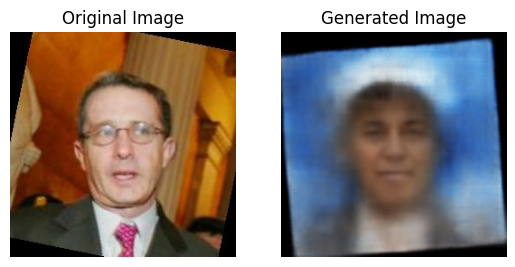

In [236]:
import matplotlib.pyplot as plt
import random
import torch

model.eval()

# Taking a random image from the dataset
random_idx = random.randint(0, len(dataloader) - 1)
original_image, _ = dataloader.dataset[random_idx]
original_image = original_image.to(device)

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(original_image.cpu().permute(1, 2, 0))
plt.title("Original Image")
plt.axis('off')

# Generating new samples and plot them
with torch.no_grad():
    sample = torch.randn(1, 20).to(device)
    generated_image = model.decode(sample).cpu().squeeze()

plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(generated_image.permute(1, 2, 0))
plt.title("Generated Image")
plt.axis('off')
plt.show()